# Baseline XGBoost model to forecast sales

> Objectives:
>
> - End goal of model is to forecast sales 6 weeks into the future.
> - Train a baseline xgboost model.
> - With minimal feature engineering, and gridsearch on hyperparams, create a base R^2 score to compare future methods against.

# Download dataset
- Manually from https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast/data
- Unzipped and renamed folder `walmart-sales`, and saved in a new folder in the root dir named `datasets`

In [26]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Dataset Description
- features.csv: Additional data related to the store, department, and regional activity for the given dates.
- train.csv: This is the historical training data, which covers 2010–02–05 to 2012-08-17.
- test.csv: Similar to train.csv, except we have to predict weekly sales.
- stores.csv: Contains anonymized information about the 45 stores, indicating the type and size of the store.

In [27]:
path = Path("../../datasets/walmart-sales")

features_df = pd.read_csv(path/"features.csv")
stores_df = pd.read_csv(path/"stores.csv")
test_df = pd.read_csv(path/"test.csv")
train_df = pd.read_csv(path/"train.csv")

In [28]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [29]:
features_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [30]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [31]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [33]:
features_df.columns = features_df.columns.str.lower()
stores_df.columns = stores_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
train_df.columns = train_df.columns.str.lower()

# Questions so far:
1. With basic data preparation, what baseline R^2 score can we get using XGBoost?
1. With a handful of grid search hyper parameters, what improvement can we expect before doing too much feature engineering?

In [34]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         8190 non-null   int64  
 1   date          8190 non-null   object 
 2   temperature   8190 non-null   float64
 3   fuel_price    8190 non-null   float64
 4   markdown1     4032 non-null   float64
 5   markdown2     2921 non-null   float64
 6   markdown3     3613 non-null   float64
 7   markdown4     3464 non-null   float64
 8   markdown5     4050 non-null   float64
 9   cpi           7605 non-null   float64
 10  unemployment  7605 non-null   float64
 11  isholiday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


# Check for missing values

In [35]:
features_df.isnull().sum()

store              0
date               0
temperature        0
fuel_price         0
markdown1       4158
markdown2       5269
markdown3       4577
markdown4       4726
markdown5       4140
cpi              585
unemployment     585
isholiday          0
dtype: int64

In [36]:
# Dropping isholiday which is contained in train_df as well.
features_df = features_df.drop(columns=["isholiday"])

# Merge train_df and features_df on 'store' and 'date'
merged_df = pd.merge(train_df, features_df, on=['store', 'date'])

# Handle dates
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['year'] = merged_df['date'].dt.year
merged_df['week_of_year'] = merged_df['date'].dt.isocalendar().week

merged_df = merged_df.drop(columns=['date'])

# Handle missing values
merged_df = merged_df.fillna(merged_df.mean())

# Display the first few rows of the merged dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         421570 non-null  int64  
 1   dept          421570 non-null  int64  
 2   weekly_sales  421570 non-null  float64
 3   isholiday     421570 non-null  bool   
 4   temperature   421570 non-null  float64
 5   fuel_price    421570 non-null  float64
 6   markdown1     421570 non-null  float64
 7   markdown2     421570 non-null  float64
 8   markdown3     421570 non-null  float64
 9   markdown4     421570 non-null  float64
 10  markdown5     421570 non-null  float64
 11  cpi           421570 non-null  float64
 12  unemployment  421570 non-null  float64
 13  year          421570 non-null  int32  
 14  week_of_year  421570 non-null  UInt32 
dtypes: UInt32(1), bool(1), float64(10), int32(1), int64(2)
memory usage: 42.6 MB


In [37]:
from sklearn.model_selection import train_test_split

# Remove duplicate rows
X = merged_df.drop(columns=['weekly_sales'])
y = merged_df['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional, NamedTuple, Callable
import functools

@dataclass(frozen=True)
class ModelConfig:
    sequence_length: int
    batch_size: int
    learning_rate: float
    hidden_size: int
    num_layers: int
    dropout: float

@dataclass(frozen=True)
class TrainingConfig:
    epochs: int
    early_stopping_patience: int

class ModelState(NamedTuple):
    model: nn.Module
    scalers: Dict[str, MinMaxScaler]
    device: torch.device

class Metrics(NamedTuple):
    rmse: float
    mae: float
    r2_test: float
    r2_train: float
    train_losses: List[float]
    val_losses: List[float]

class TimeSeriesDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]

class WalmartLSTM(nn.Module):
    def __init__(self, input_size: int, config: ModelConfig):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            batch_first=True,
            dropout=config.dropout
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(config.hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        return self.linear_layers(last_hidden)

def create_sequences(data: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, data.shape[1]-1])
    return np.array(X), np.array(y)

def prepare_scalers(df: pd.DataFrame) -> Dict[str, MinMaxScaler]:
    scalers = {}
    numerical_columns = df.select_dtypes(include=['int32', 'int64', 'float64']).columns
    
    for column in numerical_columns:
        scaler = MinMaxScaler()
        scaler.fit(df[[column]])
        scalers[column] = scaler
        
    return scalers

def scale_data(df: pd.DataFrame, scalers: Dict[str, MinMaxScaler]) -> pd.DataFrame:
    df_scaled = df.copy()
    
    for column, scaler in scalers.items():
        df_scaled[f'{column}_scaled'] = scaler.transform(df[[column]])
    
    df_scaled['isholiday_scaled'] = df_scaled['isholiday'].astype(int)
    return df_scaled

def prepare_data(
    df: pd.DataFrame,
    config: ModelConfig,
    scalers: Dict[str, MinMaxScaler]
) -> Tuple[DataLoader, DataLoader, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    df_scaled = scale_data(df, scalers)
    
    features = [f'{col}_scaled' for col in scalers.keys()] + ['isholiday_scaled']
    X, y = create_sequences(df_scaled[features].values, config.sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    
    return train_loader, test_loader, X_train, X_test, y_train, y_test

def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> float:
    model.train()
    total_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> float:
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            total_loss += criterion(outputs.squeeze(), batch_y).item()
    
    return total_loss / len(test_loader)

def predict(model: nn.Module, X: np.ndarray, device: torch.device) -> np.ndarray:
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        predictions = model(X_tensor).cpu().numpy()
    return predictions

def inverse_transform_predictions(
    predictions: np.ndarray,
    scaler: MinMaxScaler
) -> np.ndarray:
    return scaler.inverse_transform(predictions.reshape(-1, 1))

def calculate_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> Tuple[float, float, float]:
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def plot_training_history(
    train_losses: List[float],
    val_losses: List[float]
) -> None:
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()

def train_model(
    df: pd.DataFrame,
    model_config: ModelConfig,
    training_config: TrainingConfig
) -> Tuple[ModelState, Metrics]:
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    scalers = prepare_scalers(df)
    
    train_loader, test_loader, X_train, X_test, y_train, y_test = prepare_data(
        df, model_config, scalers
    )
    
    input_size = X_train.shape[2]
    model = WalmartLSTM(input_size, model_config).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=model_config.learning_rate)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    best_model_state = None
    
    for epoch in range(training_config.epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{training_config.epochs}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= training_config.early_stopping_patience:
                print("Early stopping triggered!")
                break
    
    model.load_state_dict(best_model_state)
    
    # Calculate final metrics
    train_preds = predict(model, X_train, device)
    test_preds = predict(model, X_test, device)
    
    train_preds_original = inverse_transform_predictions(train_preds, scalers['weekly_sales'])
    test_preds_original = inverse_transform_predictions(test_preds, scalers['weekly_sales'])
    y_train_original = inverse_transform_predictions(y_train, scalers['weekly_sales'])
    y_test_original = inverse_transform_predictions(y_test, scalers['weekly_sales'])
    
    rmse, mae, r2_test = calculate_metrics(y_test_original, test_preds_original)
    _, _, r2_train = calculate_metrics(y_train_original, train_preds_original)
    
    print("\nTest Set Metrics:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"R² Score: {r2_test:.4f}")
    print("\nTraining Set Metrics:")
    print(f"R² Score: {r2_train:.4f}")
    
    plot_training_history(train_losses, val_losses)
    
    model_state = ModelState(model, scalers, device)
    metrics = Metrics(rmse, mae, r2_test, r2_train, train_losses, val_losses)
    
    return model_state, metrics

def predict_future_sales(
    model_state: ModelState,
    input_data: np.ndarray
) -> np.ndarray:
    """
    Make predictions using the trained model
    input_data should be preprocessed and scaled using the same scalers
    """
    predictions = predict(model_state.model, input_data, model_state.device)
    return inverse_transform_predictions(predictions, model_state.scalers['weekly_sales'])

# Example usage
def main():
    model_config = ModelConfig(
        sequence_length=12,
        batch_size=32,
        learning_rate=0.001,
        hidden_size=64,
        num_layers=2,
        dropout=0.2
    )
    
    training_config = TrainingConfig(
        epochs=50,
        early_stopping_patience=5
    )
    
    # Assuming df is your pandas DataFrame
    model_state, metrics = train_model(df, model_config, training_config)
    
    # Make predictions
    # new_data = ... # Your new data
    # predictions = predict_future_sales(model_state, new_data)

Epoch 1/20:
Training Loss: 0.0188
Validation Loss: 0.0079
Epoch 2/20:
Training Loss: 0.0081
Validation Loss: 0.0054
Epoch 3/20:
Training Loss: 0.0061
Validation Loss: 0.0049
Epoch 4/20:
Training Loss: 0.0053
Validation Loss: 0.0041
Epoch 5/20:
Training Loss: 0.0047
Validation Loss: 0.0042
Epoch 6/20:
Training Loss: 0.0044
Validation Loss: 0.0036
Epoch 7/20:
Training Loss: 0.0043
Validation Loss: 0.0036
Epoch 8/20:
Training Loss: 0.0041
Validation Loss: 0.0037
Epoch 9/20:
Training Loss: 0.0038
Validation Loss: 0.0034
Epoch 10/20:
Training Loss: 0.0039
Validation Loss: 0.0036
Epoch 11/20:
Training Loss: 0.0038
Validation Loss: 0.0031
Epoch 12/20:
Training Loss: 0.0036
Validation Loss: 0.0034
Epoch 13/20:
Training Loss: 0.0037
Validation Loss: 0.0034
Epoch 14/20:
Training Loss: 0.0036
Validation Loss: 0.0032
Epoch 15/20:
Training Loss: 0.0035
Validation Loss: 0.0034
Epoch 16/20:
Training Loss: 0.0035
Validation Loss: 0.0033
Early stopping triggered!

Test Set Metrics:
RMSE: $85686.78
MAE:

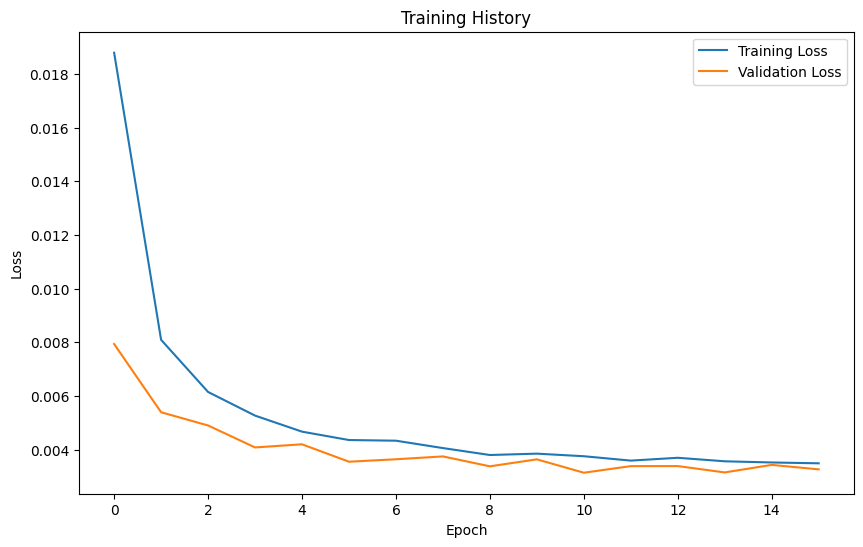

In [46]:
model_config = ModelConfig(
    sequence_length=12,
    batch_size=32,
    learning_rate=0.001,
    hidden_size=64,
    num_layers=2,
    dropout=0.2
)

training_config = TrainingConfig(
    epochs=20,
    early_stopping_patience=5
)

model_state, metrics = train_model(merged_df, model_config, training_config)
# predictions = predict_future_sales(model_state, new_data)

In [48]:
print(metrics)

Metrics(rmse=np.float64(85686.77748710378), mae=np.float64(23600.32245839385), r2_test=0.7664483745814672, r2_train=0.767275012117457, train_losses=[0.018790589215656517, 0.008093325717210444, 0.006149484312647985, 0.0052684431597502124, 0.004670684467316084, 0.004358307884396682, 0.004333273791997648, 0.004058599786446865, 0.003800348939303996, 0.0038507304372211804, 0.0037546979171485394, 0.0035914641532036828, 0.00369673124754661, 0.0035659577258160733, 0.003521948899455722, 0.003491086914043351], val_losses=[0.00793610687931201, 0.005393426824251518, 0.004900627936622117, 0.004082258519498537, 0.0041992436015333675, 0.0035503711594365656, 0.00364157554720691, 0.003747530447551539, 0.0033787096476128836, 0.0036385047541479592, 0.0031401447294708775, 0.003386059259637529, 0.0033876915547610843, 0.0031513803049330966, 0.0034317405016402146, 0.003264944790843172])


Epoch 1/20:
Training Loss: 0.0171
Validation Loss: 0.0088
Epoch 2/20:
Training Loss: 0.0074
Validation Loss: 0.0051
Epoch 3/20:
Training Loss: 0.0056
Validation Loss: 0.0045
Epoch 4/20:
Training Loss: 0.0049
Validation Loss: 0.0057
Epoch 5/20:
Training Loss: 0.0046
Validation Loss: 0.0042
Epoch 6/20:
Training Loss: 0.0045
Validation Loss: 0.0036
Epoch 7/20:
Training Loss: 0.0041
Validation Loss: 0.0034
Epoch 8/20:
Training Loss: 0.0041
Validation Loss: 0.0052
Epoch 9/20:
Training Loss: 0.0040
Validation Loss: 0.0034
Epoch 10/20:
Training Loss: 0.0039
Validation Loss: 0.0038
Epoch 11/20:
Training Loss: 0.0040
Validation Loss: 0.0040
Epoch 12/20:
Training Loss: 0.0039
Validation Loss: 0.0034
Epoch 13/20:
Training Loss: 0.0036
Validation Loss: 0.0033
Epoch 14/20:
Training Loss: 0.0037
Validation Loss: 0.0035
Epoch 15/20:
Training Loss: 0.0036
Validation Loss: 0.0034
Epoch 16/20:
Training Loss: 0.0036
Validation Loss: 0.0042
Epoch 17/20:
Training Loss: 0.0035
Validation Loss: 0.0037
Epoch 

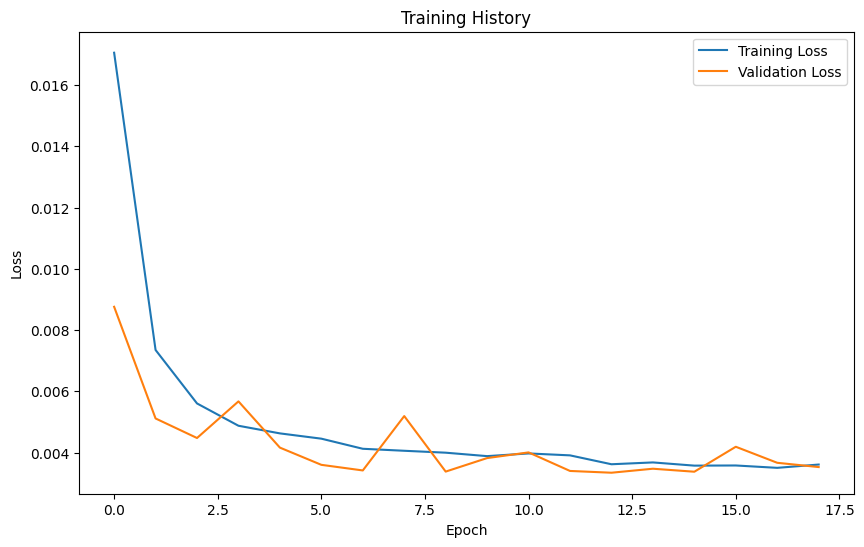

In [49]:
model_config = ModelConfig(
    sequence_length=12,
    batch_size=32,
    learning_rate=0.001,
    hidden_size=64,
    num_layers=2,
    dropout=0.1
)

training_config = TrainingConfig(
    epochs=20,
    early_stopping_patience=5
)

model_state, metrics = train_model(merged_df, model_config, training_config)

Epoch 1/20:
Training Loss: 0.0215
Validation Loss: 0.0188
Epoch 2/20:
Training Loss: 0.0108
Validation Loss: 0.0081
Epoch 3/20:
Training Loss: 0.0077
Validation Loss: 0.0064
Epoch 4/20:
Training Loss: 0.0064
Validation Loss: 0.0051
Epoch 5/20:
Training Loss: 0.0057
Validation Loss: 0.0052
Epoch 6/20:
Training Loss: 0.0053
Validation Loss: 0.0042
Epoch 7/20:
Training Loss: 0.0050
Validation Loss: 0.0054
Epoch 8/20:
Training Loss: 0.0048
Validation Loss: 0.0054
Epoch 9/20:
Training Loss: 0.0048
Validation Loss: 0.0036
Epoch 10/20:
Training Loss: 0.0043
Validation Loss: 0.0066
Epoch 11/20:
Training Loss: 0.0043
Validation Loss: 0.0037
Epoch 12/20:
Training Loss: 0.0044
Validation Loss: 0.0036
Epoch 13/20:
Training Loss: 0.0041
Validation Loss: 0.0037
Epoch 14/20:
Training Loss: 0.0042
Validation Loss: 0.0035
Epoch 15/20:
Training Loss: 0.0040
Validation Loss: 0.0039
Epoch 16/20:
Training Loss: 0.0039
Validation Loss: 0.0035
Epoch 17/20:
Training Loss: 0.0039
Validation Loss: 0.0047
Epoch 

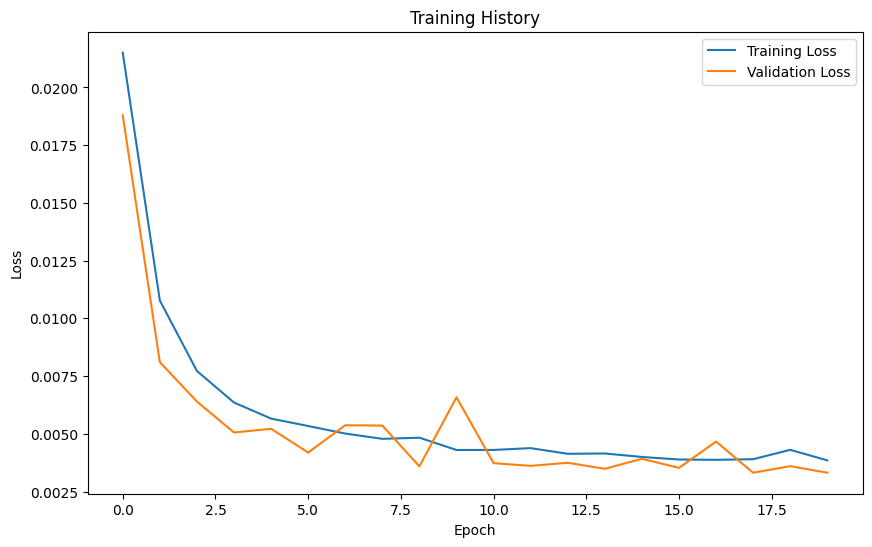

In [50]:
model_config = ModelConfig(
    sequence_length=12,
    batch_size=32,
    learning_rate=0.001,
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)

training_config = TrainingConfig(
    epochs=20,
    early_stopping_patience=5
)

model_state, metrics = train_model(merged_df, model_config, training_config)

Epoch 1/30:
Training Loss: 0.0213
Validation Loss: 0.0150
Epoch 2/30:
Training Loss: 0.0116
Validation Loss: 0.0118
Epoch 3/30:
Training Loss: 0.0082
Validation Loss: 0.0068
Epoch 4/30:
Training Loss: 0.0066
Validation Loss: 0.0071
Epoch 5/30:
Training Loss: 0.0060
Validation Loss: 0.0042
Epoch 6/30:
Training Loss: 0.0051
Validation Loss: 0.0042
Epoch 7/30:
Training Loss: 0.0044
Validation Loss: 0.0054
Epoch 8/30:
Training Loss: 0.0045
Validation Loss: 0.0035
Epoch 9/30:
Training Loss: 0.0042
Validation Loss: 0.0037
Epoch 10/30:
Training Loss: 0.0043
Validation Loss: 0.0037
Epoch 11/30:
Training Loss: 0.0041
Validation Loss: 0.0045
Epoch 12/30:
Training Loss: 0.0040
Validation Loss: 0.0048
Epoch 13/30:
Training Loss: 0.0039
Validation Loss: 0.0034
Epoch 14/30:
Training Loss: 0.0042
Validation Loss: 0.0034
Epoch 15/30:
Training Loss: 0.0038
Validation Loss: 0.0034
Epoch 16/30:
Training Loss: 0.0040
Validation Loss: 0.0036
Epoch 17/30:
Training Loss: 0.0039
Validation Loss: 0.0038
Epoch 

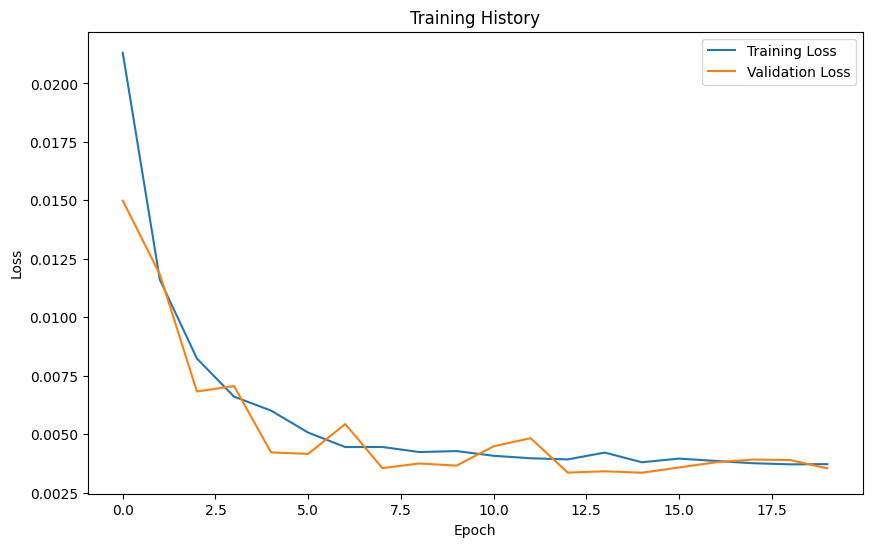

In [51]:
model_config = ModelConfig(
    sequence_length=12,
    batch_size=32,
    learning_rate=0.001,
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)

training_config = TrainingConfig(
    epochs=30,
    early_stopping_patience=5
)

model_state, metrics = train_model(merged_df, model_config, training_config)